In [1]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import camb

In [39]:
pars = camb.CAMBparams()
def get_spectra(H0=67, Ombh2=0.024, Omch2=0.12,
                tau=0.054, As=2.1e-9, ns=0.965,
                ks=0.05, kt=0.05,
                Omk=0, TCMB=2.7255, mnu=0.06,
                r=0, YHe=0.245400,
                lmax=2500, unit='muK', raw_cl=True):
    '''
    The cosmological parameter assumed here are from the abstract of the Planck 2018 results paper
    https://arxiv.org/abs/1807.06209.
    '''
    pars.set_cosmology(H0=H0, ombh2=Ombh2, omch2=Omch2, mnu=mnu, omk=Omk, tau=tau, TCMB=TCMB, YHe=YHe)
    pars.InitPower.set_params(As=As, ns=ns, r=r, pivot_scalar=ks, pivot_tensor=kt)
    pars.set_for_lmax(lmax)
    result = camb.get_results(pars)
    powers = result.get_total_cls(lmax=lmax, CMB_unit=unit, raw_cl=raw_cl)
    TT, EE, BB, TE = powers.T
    return np.array([TT, EE, BB, TE])


def smooth(map_in, input_res=np.nan, output_res_i=60, output_res_qu=None, beam=None):
    '''
    input_res: fwhm of input map, in arcmin.
    output_res: desired fwhm, in arcmin.
    '''
    print('Smoothing map...')
    out_i = output_res_i
    out_qu = output_res_qu
    nside = hp.get_nside(map_in)
    verbose=True
    #If no qu resolution specified, assume same for all:
    if output_res_qu == None:
        output_res_qu = output_res_i
    input_res = input_res * np.pi/180/60
    output_res_i= output_res_i * np.pi/180/60
    output_res_qu = output_res_qu * np.pi/180/60
    map_out = np.array(map_in)
    fwhm_i = np.sqrt(output_res_i**2-input_res**2)
    fwhm_qu = np.sqrt(output_res_qu**2 - input_res**2)
    if beam is None: 
        print('Smoothing I to {} arcmin...'.format(out_i))
        map_out[0] = np.array(hp.sphtfunc.smoothing(map_in[0], fwhm=fwhm_i, verbose=verbose))
        print('Smoothing Q, U to {} arcmin...'.format(out_qu))
        map_out[1] = np.array(hp.sphtfunc.smoothing(map_in[1], fwhm=fwhm_qu, verbose=verbose))
        map_out[2] = np.array(hp.sphtfunc.smoothing(map_in[2], fwhm=fwhm_qu, verbose=verbose))
    if beam is not None:
        orig_bell = beam
        lmax = min(len(orig_bell)-1, 3*nside-1)
        ell = np.arange(lmax+1)
        sigma2 = output_res_i**2 / 8 / np.log(2)
        sigma2_p = output_res_qu**2 / 8 / np.log(2)
        sigmas = [sigma2, sigma2_p, sigma2_p]
        spin = [0,2,2]
        bell = np.array( [np.exp(-0.5 * (ell *(ell+1) - s**2 ) * sigmas[i]) for s, i in enumerate(spin)])
        bell /= orig_bell
    return map_out


def generate_window_from_def(defInfo, lmax:int):
    """
    Calculate the windows based on definition information
    
    Parameters:
    ==========
    defInfo: iterable
        iterable of length vectors with first 3 entries as (lmin, lpeak, lmax)
    lmax: integer
        lmax of the output windows
        
    Returns:
    ==========
    Windows: ndarray
        iterable of windows based on the given window definition
    """
    windows = []
    for info in defInfo:
        ell = np.arange(lmax + 1)
        h1 = np.where((info[0] <= ell) * (ell < info[1]), np.cos((info[1] - ell) * np.pi/((info[1] - info[0]) * 2)), 0)
        h2 = (ell == info[1]).astype(float)
        h3 = np.where((info[1] < ell) * (ell <= info[2]), np.cos((ell - info[1]) * np.pi/((info[2] - info[1]) * 2)), 0)
        windows.append(h1 + h2 + h3)
    windows = np.array(windows)
    return np.where(np.isnan(windows), 0, windows)


def ilc(maps, a=None, pixelWeight=None):
    """
    Perform ILC over the list of maps.
    
    Parameters:
    ==========
    maps: iterable
        iterable of maps of same component at different frequency
    a: ndarray or None
        weighting of each component at each frequency
        Default (when value is none): array of ones for obtaining CMB component
    pixelWeight: array-like
        mask applied to the ilc maps
        Default: no mask applied
        
    Returns:
    ==========
    outputMap: array-like
        single output map.
    ilcWght: array-like
        ILC combination weighting for each component.
    """
    if a is None:
        a = np.ones(len(maps))
    if pixelWeight is None:
        pixelWeight = np.ones(len(maps[0]))
    if pixelWeight.ndim != 1:
        raise ValueError('The pixel weight / masks are expect to be 1-d (npix, ) numpy array')
    pWeight = np.transpose(np.array([[pixelWeight]]), axes=(2,0,1))
    tMaps = maps.T
    Rs = np.array([np.atleast_2d(gamma).T @ np.atleast_2d(gamma) for gamma in tMaps])
    RBar = np.sum((Rs * pWeight), axis=0) / np.sum(pixelWeight)
    ilcWght = (a.T @ np.linalg.pinv(RBar, rcond=1e-15)) / (a.T @ np.linalg.pinv(RBar, rcond=1e-15) @ a)
    outComp = ilcWght @ maps
    return outComp, ilcWght


def get_detector_beam(path: str, detector: str, detectorCount=1):
    """
    Get beam window function of WMAP for each detector
    
    Parameters:
    ==========
    path: str
        path to detector beam transfer functions of WMAP, leave detector and detector number as format field
        e.g. 'wmap_beam/wmap_ampl_bl_{}{}_9yr_v5p1.txt' where wmap_beam is the folder that stores the beam transfer functions
    detector: str
        detector band name
    detectorCount: int
        number of detectors for the band
    
    Returns:
    ==========
    beamWin: array
        Beam transfer function read using the given information.
    """
    beamW = np.array(pd.read_table(path.format(det, 1), 
                     comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])
    if detectorCount > 1:
        for ct in range(2, detectorCount + 1):
            beamW += np.array(pd.read_table(path.format(det, ct), 
                              comment='#', header=None, usecols=[0,1,2], delim_whitespace=True).loc[:, 1])
    beamW = beamW / detectorCount
    return beamW


def gaussian_smoothing(maps, inputBeam, iOutputRes, quOutputRes, nside):
    """
    Perform smoothing over the maps
    
    Parameters:
    ==========
    maps: array-like
        array of size 3 arranged in order of IQU
        (for me being too lazy, so yes, you have to have all component here)
    inputBeam: ndarray
        numpy array 
    iOutputRes: float
        output resolution of temperature component, in degree
    quOutputRes: float
        output resolution of polarization components, in degree
    nside: int
        desired output nside
    
    Returns:
    ==========
    maps: array-like
        gaussian smoothed maps
    """
    lmax = 3 * nside - 1
    alms = hp.map2alm(maps)
    resLs = [iOutputRes, quOutputRes, quOutputRes]
    sLs = [0, 2, 2]
    deconvolveBeam = 1 / beamW
    ell = np.arange(LMAX + 1)
    
    if len(deconvolveBeam) < lmax + 1:
        deconvolveBeam = np.append(deconvolveBeam, np.zeros(lmax + 1 - len(deconvolveBeam)))
    else:
        deconvolveBeam = deconvolveBeam[:lmax+1]
    
    smoothAlm = []
    for i in range(3):
        s = sLs[i]
        gfwhm = resLs[i] * np.pi / 180
        gaussian = np.exp(-0.5 * (ell * (ell + 1) - s ** 2) * gfwhm ** 2)
        deconvolvedAlm = hp.almxfl(alms[i], deconvolveBeam)
        smoothAlm.append(hp.almxfl(deconvolvedAlm, gaussian))
    return hp.alm2map(smoothAlm, nside)


def calculate_nilc_coef(maps, nilcWin, windowDefInfo):
    """
    Calculate needlet coefficient based on nilc windows and window definition
    
    Parameters:
    ==========
    maps: array-like
        array of size-3 map arrays
    nilcWin: array-like
        Array of needlet windows
    windowDefInfo: array-like
        iterable of length-4 vectors with first 3 entries as (lmin, lpeak, lmax), 
        last entry corresponds to nside of nilc Coefficient correponds to the window
        
    Returns:
    ==========
    needletCoef: array-like
        list of needlet coefficient
    """
    if len(nilcWin) != len(windowDefInfo):
        raise RuntimeError("Expect nilcWin to have the same length as WindowDefInfo")
    needletCoef = []
    for idx, fl in enumerate(nilcWin):
        tmpWghtAlms = []
        tmpWghtMaps = []
        for freqMaps in maps:
            # alm at each frequency grouped as I, Q, U
            freqAlm = np.atleast_2d(hp.map2alm(freqMaps))
            wghtFreqAlms = np.array([hp.almxfl(indivAlm, fl) for indivAlm in freqAlm])
            wghtFreqMaps = hp.alm2map(wghtFreqAlms, nside=windowDefInfo[idx][3])
            tmpWghtMaps.append(wghtFreqMaps)
        needletCoef.append(np.array(tmpWghtMaps))
    return needletCoef

In [40]:
# constants definition
NSIDE = 512
LMAX = 3 * NSIDE - 1
detectors = ['K', 'Ka', 'Q', 'V', 'W']
detectorCount = [1, 1, 2, 2, 4]

wmapDirectory = '/home/andrewliu/NILC/wmap_data/'
wmapBeamDirectory = '/home/andrewliu/NILC/wmap_beam/'
beamPath = wmapBeamDirectory + 'wmap_ampl_bl_{}{}_9yr_v5p1.txt'

I_OUTPUT_RES = 0.23
QU_OUTPUT_RES = 0.35

In [12]:
# nilc window function in Basak and Delabrouille 2011
windowDefInfo = [[0, 0, 50, 32],
                [0, 50, 100, 64],
                [50, 100, 150, 128],
                [100, 150, 250, 128],
                [150, 250, 350, 256],
                [250, 350, 550, 512],
                [350, 550, 650, 512],
                [550, 650, 800, 512],
                [650, 800, 1100, 1024],
                [800, 1100, 1500, 1024]]

nilcWin = generate_window_from_def(windowDefInfo, LMAX)
nilcWin = nilcWin / np.sum(nilcWin**2, axis=0)**0.5
nilcWin = np.where(np.isnan(nilcWin), 0, nilcWin)

/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in cos
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


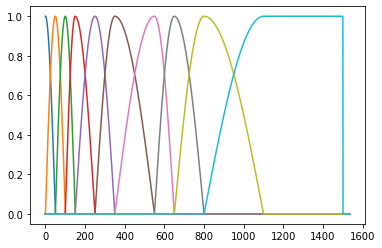

In [46]:
plt.figure()
# plt.xscale('log')
for w in nilcWin:
    plt.plot(w)

In [41]:
# get smoothed maps
smoothedMaps = []
for i in range(5):
    det = detectors[i]
    tmpMap = hp.read_map(wmapDirectory+f"wmap_band_iqumap_r9_9yr_{det}_v5.fits", field=[0, 1, 2])
    tmpMap = hp.ud_grade(tmpMap, nside_out=NSIDE)
    tmpAlm = hp.map2alm(tmpMap)
    
    # get the beam window functions, average if multiple detectors associates to a same detector.
    beamW = get_detector_beam(beamPath, det, detectorCount[i])
    
    # smooth the map
    tmpMaps = gaussian_smoothing(tmpMap, beamW, I_OUTPUT_RES, QU_OUTPUT_RES, NSIDE)
    smoothedMaps.append(tmpMaps)

# calculate the nilc coefficient
needletCoef = calculate_nilc_coef(smoothedMaps, nilcWin, windowDefInfo)

In [14]:
# perform ILC in the needlet domain
nilcCoef = []
wtLs = []
for groupj in needletCoef:
    # rearrange to separate components
    tGroupJ = np.transpose(groupj, axes=(1, 0, 2))
    compGroupJ = []
    for idx, comp in enumerate(tGroupJ):
        if idx == 0: 
            needletCMB, wt = ilc(comp)
        else:
            needletCMB, wt = ilc(comp[:4])
        compGroupJ.append(needletCMB)
        wtLs.append(wt)
        print(wt)
    nilcCoef.append(np.array(compGroupJ))

[ 0.23742463 -0.31784011 -1.82820351  4.19770458 -1.28908559]
[-0.23827664  0.38894058  0.51403311  0.33530296]
[-0.20661808  0.3769698   0.39642006  0.43322822]
[-0.12225839  0.63285687 -1.45607732  1.97168644 -0.0262076 ]
[-0.19435696  0.25092607  0.43807747  0.50535342]
[-0.17718882  0.3180435   0.44060141  0.41854392]
[-1.14648659e-02  1.83482789e-02 -7.80206242e-01  1.77310322e+00
  2.19606693e-04]
[-0.21334318  0.23207612  0.4661805   0.51508655]
[-0.06838441  0.27607446  0.41333605  0.3789739 ]
[ 0.04228521 -0.37905641 -0.24622647  1.53535278  0.0476449 ]
[-0.16629436  0.16448094  0.43961125  0.56220218]
[0.01504544 0.23334787 0.38437065 0.36723604]
[ 0.04526122 -0.40430594 -0.17463424  1.37877736  0.15490161]
[-0.07607858  0.10794967  0.37015888  0.59797002]
[0.04329801 0.19517788 0.3593411  0.402183  ]
[-0.00410755 -0.17096887 -0.24254594  0.93112762  0.48649474]
[-0.00478689  0.07740777  0.30514125  0.62223787]
[0.01774807 0.12049922 0.33698179 0.52477091]
[-0.00258202 -0.112

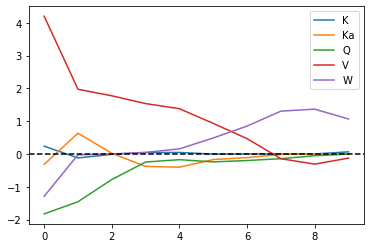

In [15]:
# visualize ILC weight
compIdx = {'I': 0, 'Q':1, 'U':2}
compSelected = 'I'
tmp = np.array([wtLs[i * 3 + compIdx[compSelected]] for i in range(10)]).T
plt.figure(figsize=(16, 9))
plt.xlabel('Needlet ILC Weight')
plt.ylabel('Needlet labe index')
for idx, wts in enumerate(tmp):
    plt.plot(wts, label=detectors[idx])
plt.legend()
plt.axhline(c='k', ls='--')

In [16]:
# convert back to maps
nilcAlmLs = [hp.map2alm(tmp) for tmp in nilcCoef]
nilcAlmLs = [hp.map2alm(hp.alm2map(tmp, nside=NSIDE)) for tmp in nilcAlmLs]

nilcAlms = np.zeros(shape=(3, len(nilcAlmLs[0][-1]))).astype('complex128')

for j in range(len(nilcWin)):
    nilcAlms += np.array([hp.almxfl(tAlm, nilcWin[j]) for tAlm in nilcAlmLs[j]])

nilcCMB = hp.alm2map(nilcAlms, nside=NSIDE)

Smoothing map...
Smoothing I to 13.8 arcmin...


Smoothing Q, U to 150 arcmin...


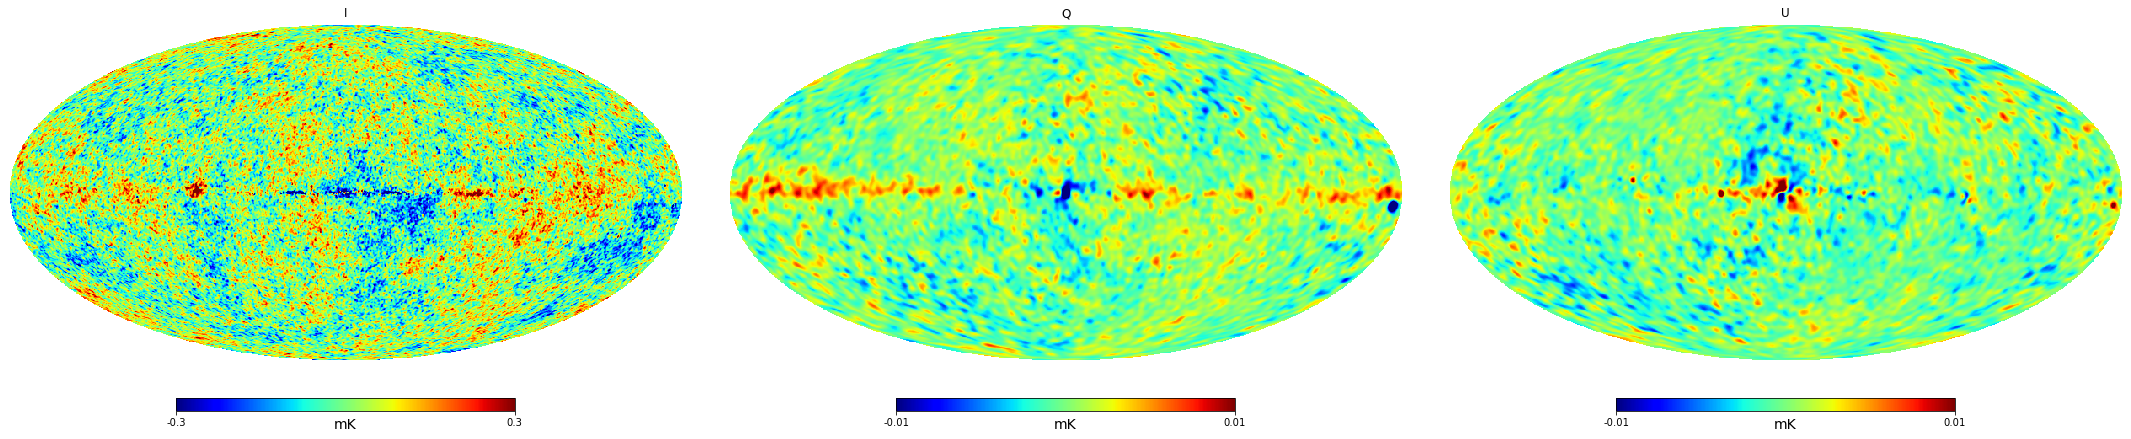

In [47]:
# show CMB plot
plt.figure(figsize=(30,10))
compName = ['I', 'Q', 'U']
val = [0.3, 0.01, 0.01]
smoothedNilcCMB = smooth(nilcCMB, I_OUTPUT_RES * 60, I_OUTPUT_RES * 60, 150)
for i in range(3):
    hp.mollview(smoothedNilcCMB[i], title=compName[i], min=-val[i], max=val[i], sub=(1,3,i + 1), unit='mK', cmap='jet')

/home/andrewliu/.local/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/andrewliu/.local/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


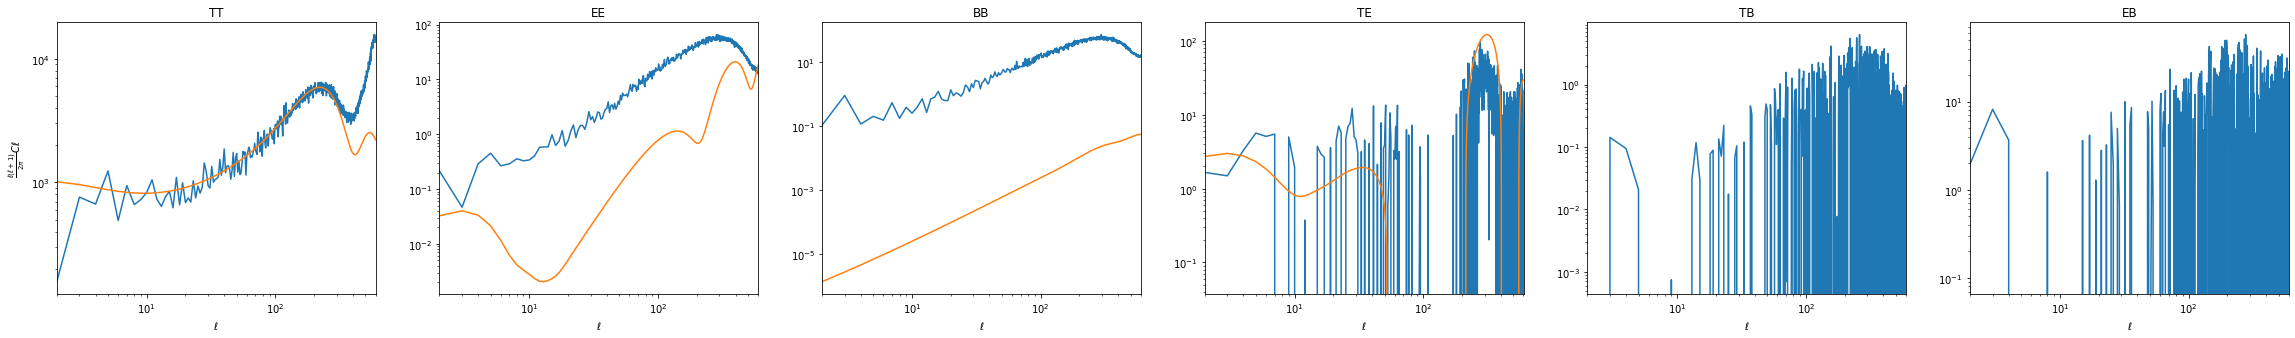

In [50]:
# visualized the power spectrum by simply apply hp.anafast()
cutDegree = 3
CLs = hp.anafast(nilcCMB, gal_cut=cutDegree)# / (np.sum(pixAngs[1] > cutDegree) / hp.nside2npix(NSIDE))
polarization = ['TT', 'EE', 'BB', 'TE', 'TB', 'EB']
plotLMAX = 600
ell = np.arange(2, plotLMAX+1)
cambCLs = get_spectra(lmax=plotLMAX)

# gaussian for de-bias
gaussian = np.exp(-0.5 * (ell * (ell + 1)) * (I_OUTPUT_RES * np.pi / 180) ** 2)
pgaussian = np.exp(-0.5 * (ell * (ell + 1) - 2 ** 2) * (QU_OUTPUT_RES * np.pi / 180) ** 2)

fig, ax = plt.subplots(1, 6)
fig.set_figheight(5)
fig.set_figwidth(40)
ax[0].set_ylabel(r'$\frac{\ell(\ell + 1)}{2\pi}C\ell$')
for i in range(6):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$\ell$')
    ax[i].set_xlim(2, plotLMAX + 1)
    ax[i].set_title(polarization[i]) 
#     if i not in [1, 2]:
    ax[i].plot(ell, CLs[i][2:plotLMAX + 1] * ell * (ell + 1) / (2 * np.pi) * 1e6 / gaussian**2)
#     else:
#         ax[i].plot(ell, CLs[i][2:plotLMAX + 1] * ell * (ell + 1) / (2 * np.pi) * 1e6 / pgaussian**2)
    if i < 4:
        ax[i].plot(ell, cambCLs[i][2:] * ell * (ell + 1) / (2 * np.pi))
    else:
        ax[i].axhline(xmax=plotLMAX, c='k', ls='--')